# 46-926, Statistical Machine Learning 1: Homework 5

*Author*  : Jordan Giebas <br>
*Due Date*: Februrary 19th, 2018 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Question 1: *Exploring ROC curves and AUC*

Using the marketing data set from HW4 and the fit glm model, determine the predicted probabilities for each points in the test data set. From these, compute the logit transformation 

$$ log\bigg(\frac{p(x_i)}{1-p(x_i)}\bigg) $$

In [2]:
# Load necessary modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
%matplotlib inline

# Load the DataFrame
df = pd.read_csv("marketing.csv")

# Adjust for categorical data
df.y = np.where(df.y == 'yes', 1, 0)
df = pd.get_dummies(df)

# Split the dataset into training and test data - as specified
X = df.drop('y', axis=1)
y = df.y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=1)

### Part (a) 

Make a histogram of your logit scores

In [3]:
%%capture
# Fit Logistic Gam
from pygam import LogisticGAM
gam = LogisticGAM().gridsearch(X_train,y_train,lam = np.logspace(-0.5, -0.25, 30))
yhat_gam = gam.predict(X_test)

In [84]:
log_pr = np.array([np.log(pr/(1-pr)) for pr in gam.predict_proba(X_test)])

In [1]:
# Define bin count
no_bins = 50

# Plot Histogram
matplotlib.rcParams['figure.figsize'] = (12,8)
plt.xlabel("Log Odds")
plt.ylabel("Number of occurrences")
plt.title("Histogram of log odds")
_, _, _ = plt.hist(log_pr, bins=100, normed=1)

NameError: name 'matplotlib' is not defined

### Part (b)

Make separate histograms for the score (value classified, i.e. {0,1}?) of each class. 

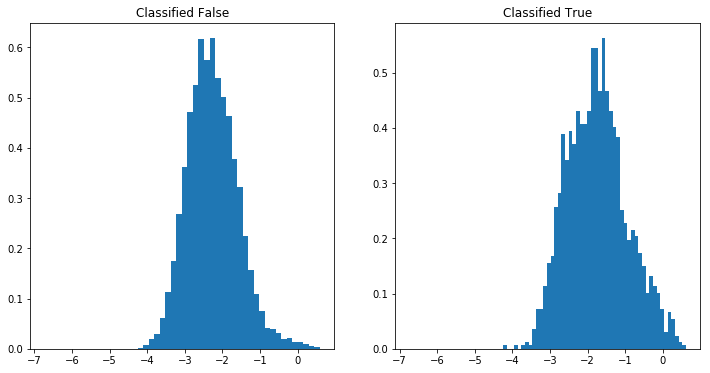

In [86]:
%matplotlib inline
fig, axs = plt.subplots(1,2,sharex=True,figsize=(12,6))

n1, _, _ = axs[0].hist(log_pr[y_test==False], bins=no_bins, normed=1)
n2, _, _ = axs[1].hist(log_pr[y_test==True],  bins=no_bins, normed=1)
axs[0].set_title('Classified False')
axs[1].set_title('Classified True')

### Part (c)

Write out integrals to describe the True/False positive rate using the cuttoff point $T$, $f_{0}(x)$ and $f_1(x)$, the distributions for score of 'no' and 'yes' respectively. <br>

Since $f_{0}(x)$ and $f_{1}(x)$ are the distributions of classifying as false or true, the cut off point and the appropriate distribution determines each of the TRP/FPR metrics. Speficically,

$$ TPR = \int_{T}^{\infty} f_{1}(x) dx $$

Similarly, 

$$ FPR = \int_{T}^{\infty} f_{0}(x) dx $$

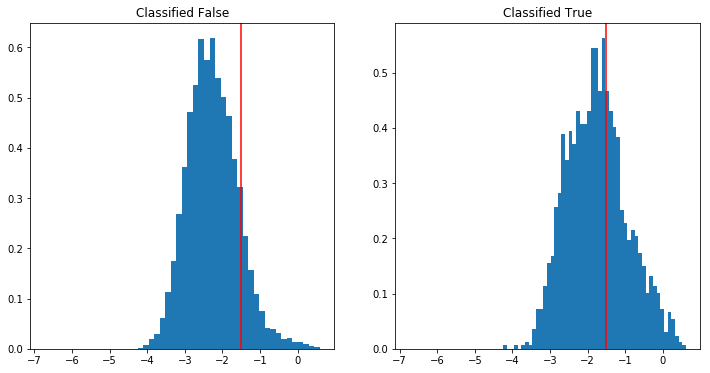

In [87]:
# Plot the above with the cutoff of T = -1.5

%matplotlib inline
fig, axs = plt.subplots(1,2,sharex=True,figsize=(12,6))

n1, _, _ = axs[0].hist(log_pr[y_test==False], bins=no_bins, normed=1)
n2, _, _ = axs[1].hist(log_pr[y_test==True],  bins=no_bins, normed=1)
axs[0].set_title('Classified False')
axs[1].set_title('Classified True')
axs[0].axvline(x=-1.5, color='red')
axs[1].axvline(x=-1.5, color='red')

It's hard to interpret in separate plots, but it seems that the area past the cutoff point $T=-1.5$ is larger for those classified as True rather than False. The plot on the (left) right past the cutoff point corresponds to the (False) True Positive Rate. 

### Part (d)

AUC is basically spelled out by the hint. It's the TPR times the rate of change of the False Postiive rate at any instant. Integrating over $T$, we see that

$$ AUC = \int_{-\infty}^{\infty} TPR(x) \frac{dFPR}{dx} dx $$

Hence,

$$ AUC = \int_{-\infty}^{\infty} \bigg( \int_{T}^{\infty} f_{1}(u) du \big)\  f_{0}(x) dx $$

### Part (e)

Let $S_{i}$ be sampled from $f_{i}(x)$ for $i = 1,2$ respectively, and recognize that 

$$ \int_{T}^{\infty} f(x) dx = \int_{-\infty}^{\infty} \mathbb{1}_{\{x > T\}} dx, \forall T $$


Then using the above, 

$$ AUC = \int_{-\infty}^{\infty} \bigg( \int_{T}^{\infty} f_{1}(u) du \big)\  f_{0}(x) dx $$
$$ AUC = \int_{-\infty}^{\infty} \bigg( \int_{-\infty}^{\infty} \mathbb{1}_{\{x > T\}} f_{1}(u) du \big)\  f_{0}(x) dx $$
$$ AUC = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \mathbb{1}_{\{x > T\}} f_{1}(u) f_{0}(x) du dx $$

Hence, it follows that

$$ AUC = \mathbb{P}\big[S_1 > S_2\big]$$


## Question 2: *DIY Sensitivity-Specificity*

### Part (a)

Define the function described in the homework.

In [27]:
# Use the equations from class
def eval_estimate(estimate, truth, loss_FP, loss_FN):
    
    neg_estimate = 1-estimate
    neg_truth    = 1-truth
    tot_zero     = len(truth) - truth.sum() # Count's no. zeros
    
    # Since they're boolean, we can perform binary ops
    sens = (estimate*truth).sum()/truth.sum()
    spec = (neg_estimate*neg_truth).sum()/tot_zero
    
    # Use asymmetric loss as seen from class / hw
    loss = loss_FP*(estimate*neg_truth).sum() + loss_FN*(neg_estimate*truth).sum()

    return(sens, spec, loss)

In [28]:
# Fit the logisitic regression, use same C from last homework
lreg = LogisticRegression(C = 10000) 
fit = lreg.fit(X_train,y_train)

# Get log probabilities
log_pr = np.array([np.log(pr/(1-pr)) for pr in fit.predict_proba(X_test)[:,1]])

# Evaluate sensitivity, specificity, and asymmetric loss from the cutoff of -1
s1,s2,l = eval_estimate(log_pr > -1, y_test, 5, 100)
    
# Report results
print("\nSensitivity: ", s1)
print("Specificity: ", s2)
print("Asymmetric Loss: ", l)
    


Sensitivity:  0.0988372093023
Specificity:  0.973181818182
Asymmetric Loss:  156770


### Part (b)

Apply this function to all cutoff points, i.e. the midpoints (using Instructors code here). 

In [29]:
unique_values = np.sort(np.unique(log_pr))
midpoints = (unique_values[0:(len(unique_values)-1)]+unique_values[1:len(unique_values)])/2.0
sens, spec, loss = np.vectorize( lambda x: eval_estimate(log_pr>x,np.array(y_test, dtype=bool), 5, 100))(midpoints)

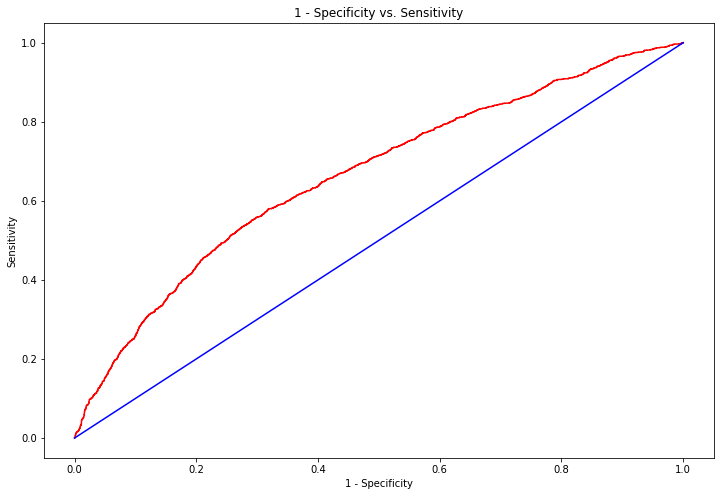

In [37]:
x_ = np.linspace(0,1,200)

matplotlib.rcParams['figure.figsize'] = (12,8)
plt.plot(1-spec, sens, 'r-', label='ROC')
plt.plot(x_, x_, 'b-', label='f(x) = x')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('1 - Specificity vs. Sensitivity')

### Part (c)

Color code the loss to tell where the loss is mostly occuring on the ROC curve above... Again, using Prof. G'Sells' code.

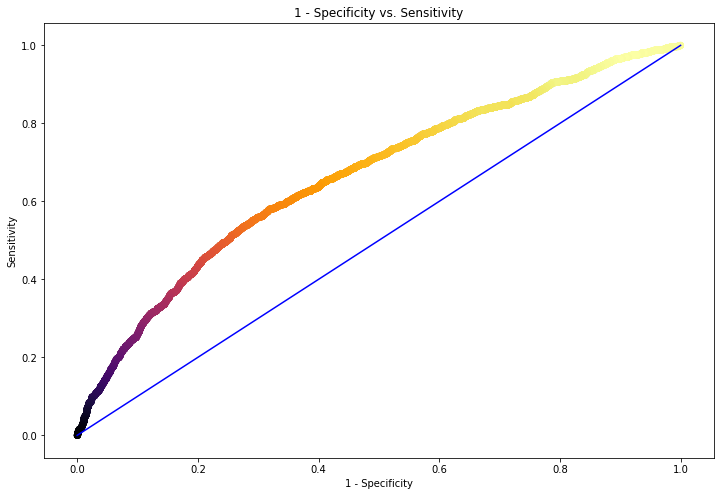

In [42]:
from matplotlib import cm 

x_ = np.linspace(0,1,200)

matplotlib.rcParams['figure.figsize'] = (12,8)
plt.scatter(1-spec, sens, c=-loss, cmap=cm.inferno)
plt.plot(x_, x_, 'b-', label='f(x) = x')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('1 - Specificity vs. Sensitivity')



I presume the darker color is associated to higher loss. Here we see high losses in the bottom left of the graph, since we use the negative of the loss vector as suggested in the homework. 

### Part (d) 

Find the minimum loss point on the curve using `np.argmin`. Plot this point by using scatter with one data point, and using the 'stolen' code from the homework. 

In [45]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

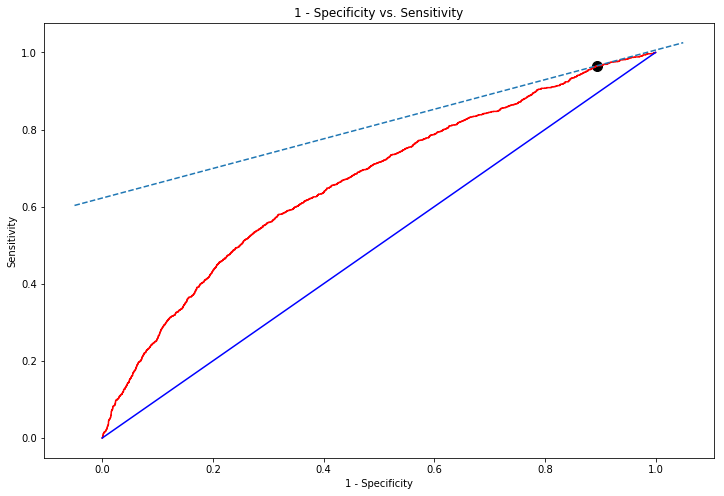

In [54]:
# Slope is \frac{N}{P} * \frac{L_{FP}}{L_{FN}}
# Note: (L_{FP}, L_{FN} = (5, 100)
m = 0.05*( (len(y_test)/y_test.sum()) - 1) 

# Minimal Loss Point
mp = np.argmin(loss)

# Intercept
b = -m*(1-spec[mp]) + sens[mp]

# Plot the appropriate figure
x_ = np.linspace(0,1,200)

# Adjust Figure Size
matplotlib.rcParams['figure.figsize'] = (12,8) 

# Plot ROC, Diag, Minimal Point, Line Connecting
plt.plot(1-spec, sens, 'r-', label='ROC') # ROC Curve
plt.plot(x_, x_, 'b-', label='f(x) = x')  # f(x) = x
plt.scatter(1-spec[mp], sens[mp], color='k', s=100) # Minimum Point
abline(m,b)

# Add features
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('1 - Specificity vs. Sensitivity')

The line passing through the minimum point seems to be tangent to the ROC curve, hence this suggests that it is the minimum. 

### Part (e)

Prove the formula <br>

#### i. 

$$ total\ loss = L_{FP}\big(N \times FPR\big) + L_{FN}\big(P \times TPR\big) $$

#### ii. 

Using Pr1c,

$$ total\ loss = L_{FP} \times N \int_{T}^{\infty} f_{0}(x) dx  + P \times L_{FP} \int_{-\infty}^{T} f_{1}(x) dx $$

#### iii.

Taking the derivative wrt x,

$$ \frac{d total\ loss}{dT} = -L_{FP}Nf_{0}(T) + P L_{FP} f_{1}(T) = 0 $$

Solving, we find that 

$$ \frac{f_1(T)}{f_0(T)} = \frac{NL_{FP}}{PL_{FN}} $$


## Question 3: *Continuation of the last problem*

### Part (a)

Compute the optimal probability threshold from the logistic regression with the same asymmetric losses.<br>

We saaw that the optimal threshold was, 

$$ ln\big(\frac{L_{FP}}{L_{FN}}\big) = ln\big(\frac{5}{100}\big) $$

In [55]:
np.log(0.05)

-2.9957322735539909

Hence, it follows that the loss at this point is 

In [60]:
T_op = np.log(0.05)
_,_, loss = eval_estimate(log_pr>T_op, y_test, 5, 100)
print("Loss: ", loss)

Loss:  65245


Comparing this to the minimal loss point used in the above problems we see that,

In [61]:
T_min_point = midpoints[np.argmin(loss)]
_,_, loss = eval_estimate(log_pr>T_min_point, y_test, 5, 100)
print("Loss: ", loss)

Loss:  65995


These are close relatively, but clearly not that close. 

### Part (b)

Plot this 'optimal' point on the ROC curve along with what's there from before. How do these two points compare? Why might they not be the same?



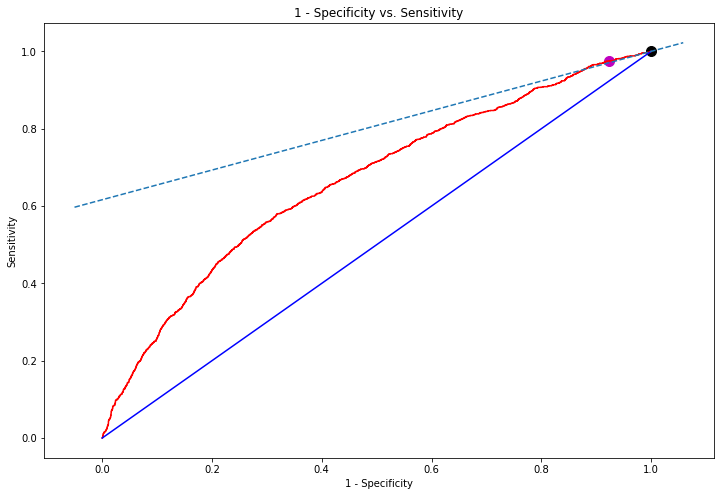

In [64]:
# Slope is \frac{N}{P} * \frac{L_{FP}}{L_{FN}}
# Note: (L_{FP}, L_{FN} = (5, 100)
m = 0.05*( (len(y_test)/y_test.sum()) - 1) 

# Minimal Loss Point
mp = np.argmin(loss)

# Intercept
b = -m*(1-spec[mp]) + sens[mp]

# Plot the appropriate figure
x_ = np.linspace(0,1,200)

# Adjust Figure Size
matplotlib.rcParams['figure.figsize'] = (12,8) 

# Plot ROC, Diag, Minimal Point, Line Connecting, ### And now the other point
plt.plot(1-spec, sens, 'r-', label='ROC') # ROC Curve
plt.plot(x_, x_, 'b-', label='f(x) = x')  # f(x) = x
plt.scatter(1-spec[mp], sens[mp], color='k', s=100) # Minimum Point
abline(m,b)
plt.scatter(1-eval_estimate(log_pr>T_op, y_test, 5, 100)[1], eval_estimate(log_pr>T_op, y_test, 5, 100)[0], color='m', s=100)

# Add features
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('1 - Specificity vs. Sensitivity')

They are reasonably close. The optimal point is derived in a perfect setting, whereas the observed minimum is from sampling a distribution. It makes sense that these two points don't necessarily need to agree, because there is a sense of randomness when drawing from the distribution. On average, one may expect the average observed point to approach the theoretical minimum. 

### Part (c)

Plot a calibration curve and histogram of the probabilities from the logistic regression. 

In [72]:
from sklearn.calibration import calibration_curve

# Get the calibration curve
x, y = calibration_curve(y_test, fit.predict_proba(X_test)[:,1], n_bins=no_bins)

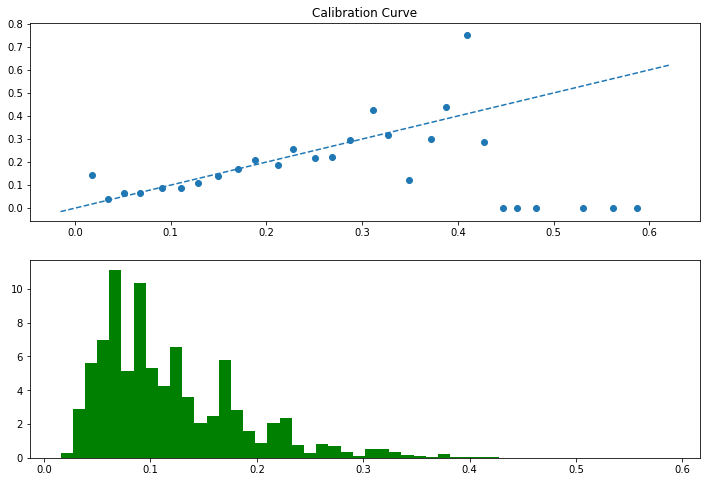

In [82]:
## Plot the results

# Subplot 1
plt.subplot(2,1,1)
plt.scatter(y,x)
abline(1,0)
plt.title('Calibration Curve')

# Subplot 2
plt.subplot(2,1,2)
_,_,_ = plt.hist(fit.predict_proba(X_test)[:,1], bins=no_bins, normed=True, color='g')

I'm sorry that I didn't have this finished. I'll make sure to manage my time more effectively, giving this talk just got in my way. 